In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
print(device)
block_size = 8
batch_size = 4
max_iters = 200000
learning_rate = 2e-4
eval_iters = 1000

cuda


In [2]:
with open('wizard_of_oz.txt', 'r', encoding='utf-8') as f:
    text = f.read()
chars = sorted(set(text))
# print(chars)
len(chars)
vocab_size = len(chars)

In [3]:
string_to_int = { ch:i for i,ch in enumerate(chars) }
int_to_string = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])


data = torch.tensor(encode(text), dtype=torch.long)
print(data[:100])

tensor([ 1,  1, 28, 39, 42, 39, 44, 32, 49,  1, 25, 38, 28,  1, 44, 32, 29,  1,
        47, 33, 50, 25, 42, 28,  1, 33, 38,  1, 39, 50,  0,  0,  1,  1, 26, 49,
         0,  0,  1,  1, 36, 11,  1, 30, 42, 25, 38, 35,  1, 26, 25, 45, 37,  0,
         0,  1,  1, 25, 45, 44, 32, 39, 42,  1, 39, 30,  1, 44, 32, 29,  1, 47,
        33, 50, 25, 42, 28,  1, 39, 30,  1, 39, 50,  9,  1, 44, 32, 29,  1, 36,
        25, 38, 28,  1, 39, 30,  1, 39, 50,  9])


In [4]:
#step 1 : 80-20 split of training and test data
n = int(0.8*len(data))
train_data = data[:n]
val_data = data[n:]

#get 5 characters and try to guess the next one
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device) #push x,y to GPU 
    
    return x, y

x, y = get_batch('train')
print('inputs:')
# print(x.shape)
print(x)
print('targets:')
print(y)

inputs:
tensor([[ 1, 65, 58, 54, 57, 72,  1, 73],
        [ 3,  1, 61, 58,  1, 56, 68, 67],
        [72, 72, 54, 60, 58, 11,  1, 33],
        [ 1, 76, 58,  1, 68, 67, 65, 78]], device='cuda:0')
targets:
tensor([[65, 58, 54, 57, 72,  1, 73, 68],
        [ 1, 61, 58,  1, 56, 68, 67, 73],
        [72, 54, 60, 58, 11,  1, 33, 73],
        [76, 58,  1, 68, 67, 65, 78,  1]], device='cuda:0')


In [5]:
class BigramLanguageModel(nn.Module):
    #
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    #
    def forward(self, index, targets=None):
        logits = self.token_embedding_table(index)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss


    def generate(self, index, max_new_tokens):
        # index is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self.forward(index)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            index_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            index = torch.cat((index, index_next), dim=1) # (B, T+1)
        return index

model = BigramLanguageModel(vocab_size)
m = model.to(device)

context = torch.zeros((1,1), dtype=torch.long, device=device)
generated_chars = decode(m.generate(context, max_new_tokens=500)[0].tolist())
print(generated_chars)


]Z7JZeD2Bwhr.?[mJlNRftw,-IMz-v
W:T2f(lJK(-P'?h"r[vmrnVJO
?5QKI"Ofp;?04RQ"tLR976?!Yl
;FWowMcRR4oOfBk.p1;uDM-n7!E'g95nLk4!SLL5!Qaj[SNVT2PZS.ugEl00LjhMz;h:sxxI345kj:Fq BFQf5s1tb3Ue9,WTp*ZC1_v&yDX7B4tCKDx52,G1)IUS,KLrBY_hP3GS! hVmG7,N8]EE]o2DU!,NhrG.[".?.;_7'P1I!jA[0Jp)S'4d:*VK_R
2.?,ecYFQ6KP37'KqV6H6xGBpgRYQ_uPDxJEkc SMc]j-'9vDP'PSL9A:Wo(HumewjkaF8A"&GU&I4RH6CV:
&mwcBgRv:lcc4t:2&RBU!Y9OjxV"q?slqM-i(9(.?*qMnJvz8Gel[ ljV?;b1RJFaQ"k?b0Me!msIMx9s1JXTPUSkIMXjK[*OpI44![eaXk?J9jds-mBJ";"O
8wqvkRVj'[!YSg4R


In [6]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [7]:
train_steps = []
train_losses = []
val_losses = []

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    if iter % eval_iters == 0:
        losses = estimate_loss()

        train_steps.append(iter)
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

        print(
            f"step: {iter}, "
            f"train loss: {losses['train']:.3f}, "
            f"val loss: {losses['val']:.3f}"
        )

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


step: 0, train loss: 4.767, val loss: 4.764
step: 1000, train loss: 4.603, val loss: 4.601
step: 2000, train loss: 4.446, val loss: 4.454
step: 3000, train loss: 4.297, val loss: 4.313
step: 4000, train loss: 4.154, val loss: 4.168
step: 5000, train loss: 4.026, val loss: 4.029
step: 6000, train loss: 3.905, val loss: 3.914
step: 7000, train loss: 3.789, val loss: 3.803
step: 8000, train loss: 3.677, val loss: 3.691
step: 9000, train loss: 3.564, val loss: 3.597
step: 10000, train loss: 3.466, val loss: 3.492
step: 11000, train loss: 3.390, val loss: 3.407
step: 12000, train loss: 3.311, val loss: 3.318
step: 13000, train loss: 3.236, val loss: 3.260
step: 14000, train loss: 3.161, val loss: 3.200
step: 15000, train loss: 3.109, val loss: 3.131
step: 16000, train loss: 3.061, val loss: 3.067
step: 17000, train loss: 3.003, val loss: 3.019
step: 18000, train loss: 2.950, val loss: 2.968
step: 19000, train loss: 2.920, val loss: 2.949
step: 20000, train loss: 2.859, val loss: 2.893
step:

2.2287611961364746


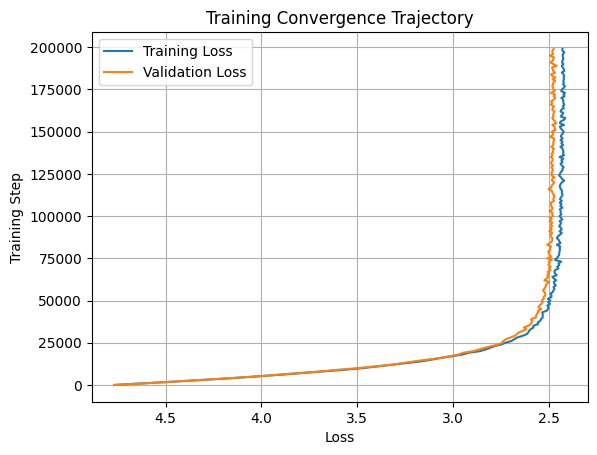

In [11]:
print(loss.item())

# Loss on X-axis, step on Y-axis
plt.plot(train_losses, train_steps, label="Training Loss")
plt.plot(val_losses, train_steps, label="Validation Loss")

plt.xlabel("Loss")
plt.ylabel("Training Step")
plt.title("Training Convergence Trajectory")

plt.gca().invert_xaxis()  
# plt.gca().invert_yaxis()  

plt.legend()
plt.grid(True)
plt.show()

In [20]:
context = torch.zeros((1,1), dtype=torch.long, device=device)
generated_text = decode(m.generate(context, max_new_tokens=1000)[0].tolist())
print(generated_text)


th anint orord  ced d and he s. bbtrsesed-HAlienokisorciligansps thed mod ten Afry  co " heautisk; a th, p. ty tondon bex Whes y irast pe an's leathared are sat rkana ners R."
"Yof
socorim. w ithe tat Doand'sho she outan ilingrd, ware geshey ' an witra Jinghel rndghit
Tho wakiconndoure  s  hyoun ntsinginthuppead apsizanssid fo theralllle r tulinged fisepoon by oft th nt f iforte othommevit als wa Bldey borcrviat ad atilled ushyo ind wo the hed thit! s. Gounug cem  diz bousisin che t l-Ind
Cand b,  t s Gaccamed tooksangerry y-se inoff. y ld us, asesotorey  w who oameand
lm thararer
le f t y't inon "
f atitite ot;
"Pry the sled APANoore t whett heslit ndean w kacinl!"o cly wickalard.
An Wompans or PTheatenthe, ovel Ilishefo raig fin Vinceangroovy ispowelid hems upar s, hit m Mano te s w ind. th.
ca a lly rsuf In inge thedoun nd sherovento owe o
" warean to then.
thakin.]

"

Them y ouslle wo avol apinousme crt wolinoupaneroast they, ay fasorel mawang thed lo boowafoung me
lly he w gge, 